# Rice Leaf Diseases Classification

In [1]:
!pip install tensorflow==2.9

  Using cached tensorflow-2.9.0-cp39-cp39-win_amd64.whl.metadata (3.0 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.9.0-cp39-cp39-win_amd64.whl (444.0 MB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


Import library yang dibutuhkan

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

print(tf.__version__)

2.9.0


Memisahkan training, validation dan testing direktori lalu mengecek total foto tiap kelas dari seluruh direktori

In [3]:
def check_total_img(dir, data_dir):
  for folder in os.listdir(dir):
    item_path = os.path.join(dir, folder)

    print(f'Total foto {data_dir} {folder}: {len(os.listdir(item_path))}')

In [4]:
training_dir = 'your_directory'
val_dir = 'your_directory'
test_dir = 'your_directory'

check_total_img(training_dir, 'Training')
print('\n')

check_total_img(val_dir, 'Validasi')
print('\n')

check_total_img(test_dir, 'Testing')

Total foto Training Bacterialblight: 1160
Total foto Training Blast: 1160
Total foto Training Brownspot: 1160
Total foto Training Healthy: 1160
Total foto Training Tungro: 1160


Total foto Validasi Bacterialblight: 145
Total foto Validasi Blast: 145
Total foto Validasi Brownspot: 145
Total foto Validasi Healthy: 145
Total foto Validasi Tungro: 145


Total foto Testing Bacterialblight: 145
Total foto Testing Blast: 145
Total foto Testing Brownspot: 145
Total foto Testing Healthy: 145
Total foto Testing Tungro: 145


Melihat sampel foto tiap kelas menggunakan matplotlib

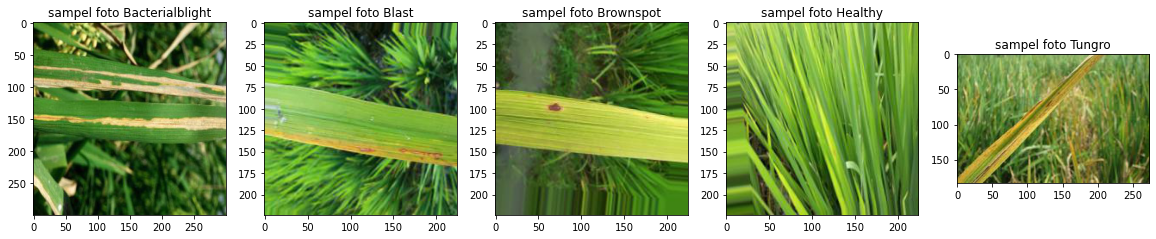

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(4 * 5, 5))

for i, folder in enumerate(os.listdir(training_dir)):
  item_path = os.path.join(training_dir, folder)
  sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
  axs[i].imshow(sample_image)
  axs[i].set_title(f'sampel foto {folder}')

plt.show()

Melihat total pixel dari setiap foto

In [6]:
for folder in os.listdir(training_dir):
  item_path = os.path.join(training_dir, folder)

  sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')

  sample_array = img_to_array(sample_image)

  print(f'Sampel foto {folder} memiliki pixel : {sample_array.shape}')

Sampel foto Bacterialblight memiliki pixel : (300, 300, 3)
Sampel foto Blast memiliki pixel : (224, 224, 3)
Sampel foto Brownspot memiliki pixel : (224, 224, 3)
Sampel foto Healthy memiliki pixel : (224, 224, 3)
Sampel foto Tungro memiliki pixel : (184, 274, 3)


Membuat fungsi untuk membuat generator bagi datasets training, validation dan testing

In [69]:
image_size = (300, 300)

def train_val_generators(train_dir, val_dir, test_dir):
  datagen = ImageDataGenerator()

  train_generator = datagen.flow_from_directory(directory=train_dir,
                                                batch_size=64,
                                                class_mode='categorical',
                                                target_size=image_size)

  val_generator = datagen.flow_from_directory(directory=val_dir,
                                              batch_size=32,
                                              class_mode='categorical',
                                              target_size=image_size)

  test_generator = datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                               target_size=image_size)

  return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = train_val_generators(training_dir, val_dir, test_dir)


Found 5800 images belonging to 5 classes.
Found 725 images belonging to 5 classes.
Found 725 images belonging to 5 classes.


Membuat model dengan menggunakan EfficientNetB3 sebagai base model

In [75]:
def create_model():
  base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=image_size + (3,))

  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)


  output = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  return model

Melihat arsitektur model

In [76]:
model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 300, 300, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 150, 150, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 150, 150, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 150, 150, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 151, 151, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 75, 75, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 75, 75, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 75, 75, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 38, 38, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 19, 19, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 19, 19, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 19, 19, 96)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 19, 19, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 19, 19, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 19, 19, 576)  55296       ['block4e_add[0][0]']            
          

                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 19, 19, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 19, 19, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_b

 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 19, 19, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 19, 19, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
          

 )                              )                                                                 
                                                                                                  
 block6b_activation (Activation  (None, 10, 10, 1392  0          ['block6b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_s

 )                              )                                                                 
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1392)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
          

 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 10, 10, 1392  0           ['block6f_activation[0][0]',     
                                )                                 'block6f_se_expand[0][0]']      
          

 block7b_se_excite (Multiply)   (None, 10, 10, 2304  0           ['block7b_activation[0][0]',     
                                )                                 'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 10, 10, 384)  884736      ['block7b_se_excite[0][0]']      
                                                                                                  
 block7b_project_bn (BatchNorma  (None, 10, 10, 384)  1536       ['block7b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 10, 10, 384)  0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_a

In [77]:
filepath = 'model2.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

Memulai masa training

In [78]:
history = model.fit(train_generator,
          epochs = 30,
          validation_data = val_generator,
          callbacks=[checkpoint])

Epoch 1/30
91/91 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.7897
Epoch 1: val_loss improved from inf to 0.45520, saving model to model2.h5
91/91 [==============================] - 418s 5s/step - loss: 0.6174 - accuracy: 0.7897 - val_loss: 0.4552 - val_accuracy: 0.8497
Epoch 2/30
91/91 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9253
Epoch 2: val_loss improved from 0.45520 to 0.32928, saving model to model2.h5
91/91 [==============================] - 408s 4s/step - loss: 0.2806 - accuracy: 0.9253 - val_loss: 0.3293 - val_accuracy: 0.9117
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9514
Epoch 3: val_loss improved from 0.32928 to 0.27494, saving model to model2.h5
91/91 [==============================] - 400s 4s/step - loss: 0.2004 - accuracy: 0.9514 - val_loss: 0.2749 - val_accuracy: 0.9228
Epoch 4/30
91/91 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9605
Epoc

Epoch 29/30
91/91 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9966
Epoch 29: val_loss did not improve from 0.14420
91/91 [==============================] - 380s 4s/step - loss: 0.0232 - accuracy: 0.9966 - val_loss: 0.1530 - val_accuracy: 0.9628
Epoch 30/30
91/91 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9971
Epoch 30: val_loss did not improve from 0.14420
91/91 [==============================] - 381s 4s/step - loss: 0.0221 - accuracy: 0.9971 - val_loss: 0.1521 - val_accuracy: 0.9669


In [74]:
# tf.keras.backend.clear_session()

Membuat fungsi untuk menampilkan plot akurasi dan loss untuk data training dan validasi semasa training

In [79]:
def create_plot(history, string):
  plt.plot(history.history[string], 'r', label='Training ' + string)
  plt.plot(history.history['val_' + string], 'b', label='Validation ' + string)
  plt.title('Training and validation ' + string)
  plt.legend()
  plt.show()
  print('')

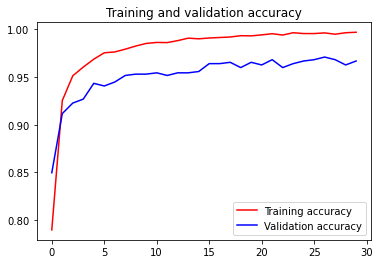

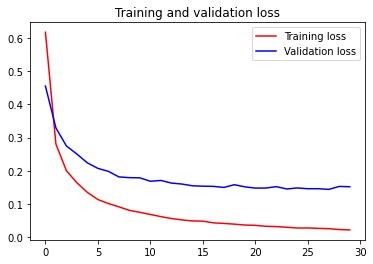

In [80]:
create_plot(history, 'accuracy')
create_plot(history, 'loss')

Evaluasi model dengan data testing

In [136]:
model.evaluate(test_generator)

23/23 [==============================] - 49s 2s/step - loss: 0.0579 - accuracy: 0.9807


[0.05790409445762634, 0.9806896448135376]

Mengambil Hasil prediksi tertinggi untuk bisa memplot confusion matrix dan matriks evaluasi lainnya

In [137]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

23/23 [==============================] - 46s 2s/step


Membuat fungsi untuk menampilkan confusion matrix

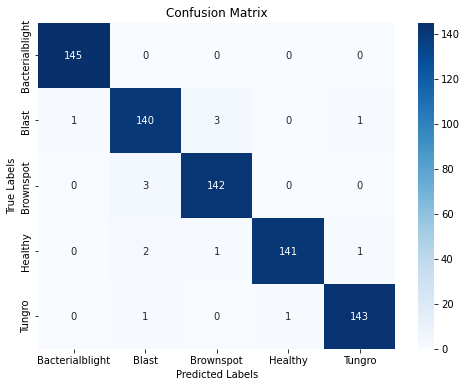

In [138]:
def plot_confusion_matrix(test_generator, y_true, y_pred):
  class_names = list(test_generator.class_indices.keys())

  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

plot_confusion_matrix(test_generator, y_true, y_pred)

Melihat matriks evaluasi precision, recall dan f1-score

In [139]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       145
           1       0.96      0.97      0.96       145
           2       0.97      0.98      0.98       145
           3       0.99      0.97      0.98       145
           4       0.99      0.99      0.99       145

    accuracy                           0.98       725
   macro avg       0.98      0.98      0.98       725
weighted avg       0.98      0.98      0.98       725



Save model

In [140]:
model.save('model.h5')

Membuat fungsi untuk preprocess gambar yang akan diinput dan gambar yang akan ditampilkan

In [141]:
def open_image(img, size, raw_img=False):
  image = load_img(img, target_size=size)
  img = img_to_array(image)
  img = np.expand_dims(img, axis=0)
  preprocess_img = preprocess_input(img)
  
  if raw_img:
    return preprocess_img, image
  else:
    return preprocess_img

Membuat fungsi yang akan menghasilkan heatmap Grad-CAM untuk suatu gambar

In [142]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model(
      model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

Membuat fungsi untuk memvisualisasikan heatmap Grad-CAM pada sebuah foto dan menyimpan foto tersebut

In [143]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = load_img(img_path)
  img = img_to_array(img)

  heatmap = np.uint8(255 * heatmap)

  jet = mpl.colormaps["jet"]

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

  superimposed_img.save(cam_path)

  display(Image(cam_path))

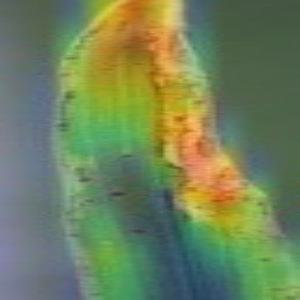

In [145]:
from IPython.display import Image, display
import matplotlib as mpl

prediksi = 'your_directory/prediksi.jpg'
contoh = 'your_directory/contoh.jpg'
preprocess_img = open_image(contoh, size=image_size)
heatmap = make_gradcam_heatmap(preprocess_img, model, 'top_conv')

save_and_display_gradcam(contoh, heatmap)

Memanggil model yang telah disave

In [127]:
'''
model = '/content/model.h5'

'''

"\nmodel = '/content/model.h5'\n\n"

Membuat fungsi untuk memprediksi gambar yang diinput

In [130]:
def predict_image(img, size):
  preprocess_img, image = open_image(img, size, raw_img=True)
  predictions = model.predict(preprocess_img)
  predicted_class_idx = np.argmax(predictions)
  class_indices = train_generator.class_indices
  labels = list(class_indices.keys())
  predicted_class_label = labels[predicted_class_idx]

  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Predicted Label: {predicted_class_label}')
  plt.show()

Prediksi gambar yang diinput

1/1 [==============================] - 0s 120ms/step


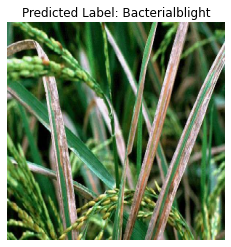

In [131]:
predict_image(prediksi, image_size)